In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("hour.csv", parse_dates=["dteday"])
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB


In [4]:
X = df.drop(columns=["instant", "cnt", "casual", "registered"])
y = df["cnt"]

In [5]:
import numpy as np

In [6]:
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer

In [7]:
def ffill_missing(ser):
    return ser.fillna(method="ffill")

In [8]:
ffiller = FunctionTransformer(ffill_missing)

In [9]:
weather_enc = make_pipeline(
    ffiller,
    OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=X["weathersit"].nunique()
    ),
)
weather_enc

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function ffill_missing at 0x00000189FA446430>)),
                ('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=4))])

In [10]:
ct = make_column_transformer(
    (ffiller, make_column_selector(dtype_include=np.number)),
    (weather_enc, ["weathersit"]),
)
ct

ColumnTransformer(transformers=[('functiontransformer',
                                 FunctionTransformer(func=<function ffill_missing at 0x00000189FA446430>),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001898AE3B820>),
                                ('pipeline',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function ffill_missing at 0x00000189FA446430>)),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=4))]),
                                 ['weathersit'])])

In [11]:
from sklearn.pipeline import FeatureUnion, make_union

In [12]:
def is_weekend(data):
    return (
        data["dteday"]
        .dt.day_name()
        .isin(["Saturday", "Sunday"])
        .to_frame()
    )

In [13]:
def year(data):
    # Our reference year is 2011, the beginning of the training dataset
    return (data["dteday"].dt.year - 2011).to_frame()

In [14]:
preprocessing = FeatureUnion([
    ("is_weekend", FunctionTransformer(is_weekend)),
    ("year", FunctionTransformer(year)),
    ("column_transform", ct)
])
preprocessing

FeatureUnion(transformer_list=[('is_weekend',
                                FunctionTransformer(func=<function is_weekend at 0x000001898AE4C0D0>)),
                               ('year',
                                FunctionTransformer(func=<function year at 0x000001898AE4C040>)),
                               ('column_transform',
                                ColumnTransformer(transformers=[('functiontransformer',
                                                                 FunctionTransformer(func=<function ffill_missing at 0x00000189FA446430>),
                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001898AE3B820>),
                                                                ('pipeline',
                                                                 Pipeline(steps=[('functiontransformer',
                                                                                  FunctionTransformer(func=<function ffill_missing at 0x00000189FA446430>)),
                                                                                 ('ordinalencoder',
                                                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                 unknown_value=4))]),
                                                                 ['weathersit'])]))])

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
reg = Pipeline([("preprocessing", preprocessing), ("model", RandomForestRegressor())])
reg

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('is_weekend',
                                                 FunctionTransformer(func=<function is_weekend at 0x000001898AE4C0D0>)),
                                                ('year',
                                                 FunctionTransformer(func=<function year at 0x000001898AE4C040>)),
                                                ('column_transform',
                                                 ColumnTransformer(transformers=[('functiontransformer',
                                                                                  FunctionTransformer(func=<function ffill_missing at 0x00000189...
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001898AE3B820>),
                                                                                 ('pipeline',
                                                                                  Pipeline(steps=[('functiontransformer',
                                                                                                   FunctionTransformer(func=<function ffill_missing at 0x00000189FA446430>)),
                                                                                                  ('ordinalencoder',
                                                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                  unknown_value=4))]),
                                                                                  ['weathersit'])]))])),
                ('model', RandomForestRegressor())])

In [17]:
X_train, y_train = X.loc[X["dteday"] < "2012-10"], y.loc[X["dteday"] < "2012-10"]
X_test, y_test = X.loc["2012-10" <= X["dteday"]], y.loc["2012-10" <= X["dteday"]]

In [18]:
reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('is_weekend',
                                                 FunctionTransformer(func=<function is_weekend at 0x000001898AE4C0D0>)),
                                                ('year',
                                                 FunctionTransformer(func=<function year at 0x000001898AE4C040>)),
                                                ('column_transform',
                                                 ColumnTransformer(transformers=[('functiontransformer',
                                                                                  FunctionTransformer(func=<function ffill_missing at 0x00000189...
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001898AE3B820>),
                                                                                 ('pipeline',
                                                                                  Pipeline(steps=[('functiontransformer',
                                                                                                   FunctionTransformer(func=<function ffill_missing at 0x00000189FA446430>)),
                                                                                                  ('ordinalencoder',
                                                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                  unknown_value=4))]),
                                                                                  ['weathersit'])]))])),
                ('model', RandomForestRegressor())])

In [19]:
reg.score(X_test, y_test)

0.8065557138260973

In [20]:
y_pred = reg.predict(X_test)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [22]:
%matplotlib inline

(15100.0, 15500.0)

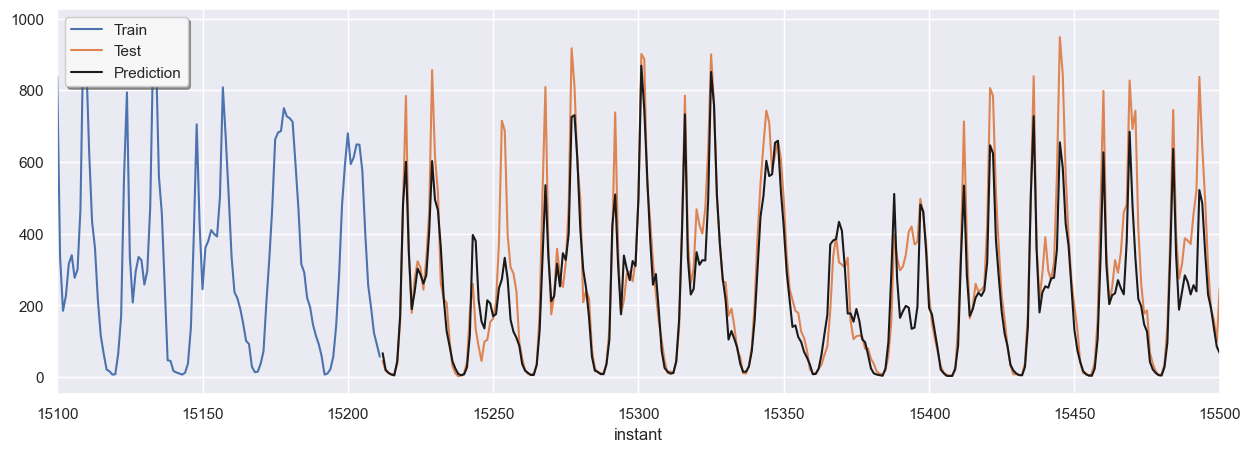

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

df.loc[df["dteday"] < "2012-10"].set_index("instant")["cnt"].plot(ax=ax, label="Train")
df.loc["2012-10" <= df["dteday"]].set_index("instant")["cnt"].plot(ax=ax, label="Test")

pd.Series(y_pred, index=df.loc["2012-10" <= df["dteday"], "instant"]).plot(ax=ax, color="k", label="Prediction")

ax.legend(loc=2, shadow=True, facecolor="0.97")
ax.set_xlim(15100, 15500)

---

In [24]:
X_train.head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0
1,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0
2,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0
3,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0
4,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0


In [25]:
reg.predict(pd.DataFrame([[
    pd.to_datetime("2015-06-07"),
    10,
    "Clear, Few clouds, Partly cloudy, Partly cloudy",
    0.3,
    0.31,
    0.8,
    0.0,
]], columns=[
    'dteday',
    'hr',
    'weathersit',
    'temp',
    'atemp',
    'hum',
    'windspeed'
]))

array([161.09])